# Noise Model

In this notebook we take a closer look at the noise model and how it holds up under discretization.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes
from Noise import Noise

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian
from NavigationCircle import NavigationCircle as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test_2d = 100  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

n_steps = 500

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 50  # discretization parameter (1D) for FOM
meshDim_drone = 2  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

## Setup

For the purposes of this notebook we go back to a simple flight in a circle. It's not actually important here, and can be switched out for any other flight path parameterization. 

In [3]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

Runtime of this block: 2.7984321117401123 s


In [4]:
# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

# point-wise measurements
detector = DetectorPointwise(fom)
#detector = DetectorUniform(fom, radius=radius, meshDim=meshDim_drone)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

## Inverse problems

We are primarily considering two types of inverse problems: the deterministic and the Bayesian. There are a lot of parallels between them, to the point that for the optimization we can treat them equivalently. The main difference lies in where the matrix over which we optimize (i.e. the information matrix / the posterior covariance matrix) comes from. 

In [5]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

# fly in a circle
alpha = np.array([0.25, 0.2])
flight = drone.plan_flight(alpha=alpha)

# measure data
data = drone.measure(flight=flight, state=state)

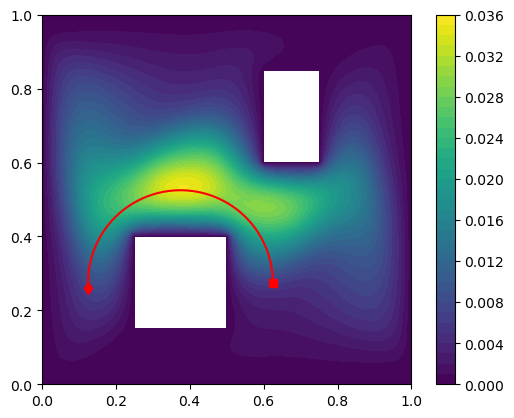

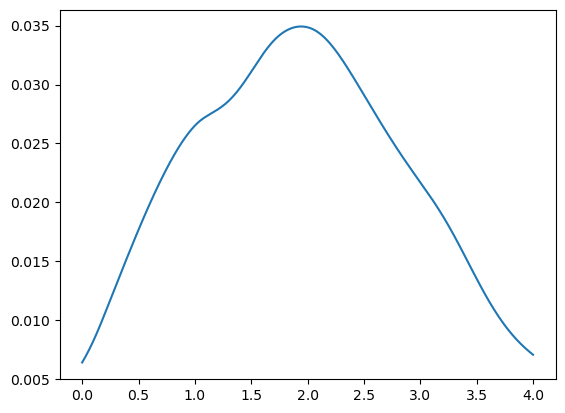

In [6]:
flightpath, grid_t = flight.flightpath, flight.grid_t

fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

fig, ax = plt.subplots(1,1)
ax.plot(grid_t, data)

### Deterministic
This is the model form that we've been using in the previous notebooks (without telling you). It's a bit easier to explain. Suppose we know the data $d$ lies in a Hilbert space $\mathcal{H} \subset L^2([0, T])$. Then, given observational data $d_{obs}$, we can pose the inverse problem as
$$
\min_{m} c_s \| d-d_{obs}\|_{\mathcal{H}}^2 + \|m-m_{pr}\|_{\Sigma_{pr}^{-1}}^2
\quad \text{such that $d$ is the measurement of the state $u(m)$}
$$
where $c_2 > 0$ is a scaling parameter. After discretization in time, the Hessian $\mathbf{H}$ of this problem, a.k.a. the \red{inverse?} Fisher information matrix, is
$$
\mathbf{H} = c_s \mathcal{F}^T \mathbf{I}_{\mathcal{H}} \mathcal{F} + \Sigma_{pr}^{-1}
$$
where $\mathbf{I}_{\mathcal{H}}$ is the inner product matrix for $\mathcal{H}$ and $\mathcal{F}$ the discretized parameter-to-observable map. If, abusing notation, we define
$$
\Sigma_{noise}^{-1} := c_s \mathbf{I}_{\mathcal{H}},
$$
then we arrive at the same matrix structure as in the Bayesian setting. The only "complication" we have is to choose the Hilbert space $\mathcal{H}$. The simplest choice that doesn't require any knowledge about the properties of the data beyond $d \in L^2([0,T])$ is to choose $\mathcal{H} = L^2([0,T])$ (duh!). In this case we have
$$
\Sigma_{noise}^{-1} := c_s \mathbf{M},
$$
where $\mathbf{M}$ is the mass matrix for the discretization of $\mathcal{H}$. Another obvious choice is $\mathcal{H} = H^1([0,T])$, in which case
$$
\Sigma_{noise}^{-1} := c_s c_d \mathbf{A} + c_s \mathbf{M},
$$
with stiffness matrix $\mathbf{A}$ and a diffusion scaling coefficient $c_d$. This choice penalizes large derivativess in the data, as caused by noise, and is therefore attractive. It can however be tricky in the time continuous limit to show that the data is indeed weakly differentiable.

In [7]:
inversion = InverseProblem(fom, drone)
inversion.set_noise_model(c_scaling = 1e+6, c_diffusion=0)
print("Norm of the data:", np.sqrt(inversion.compute_noisenorm2(data)))

Norm of the data: 48.749949241307014


In [8]:
posterior = inversion.compute_posterior(flight=flight)
covar = posterior.compute_covariance()
covar

/Users/nicole/git/m2dtIceSheet/notebooks/../source/InverseProblem.py:240: UserWarning: InverseProblem.get_states: No saved states. Computing and saving with standard basis.
  warnings.warn(


array([[ 0.00088159, -0.00057385],
       [-0.00057385,  0.00256409]])

### Bayesian setting

We model the noise $\eta$ to be distributed as $\eta \sim \mathcal{N}(0, \mathcal{C})$ with covariance operator $\mathcal{C} = \mathcal{A}^{-1}$ defined through the squared inverse laplacian-like operator $\mathcal{A}$. The operator $\mathcal{A} : L^2((0, T)) \rightarrow L^2((0,T))$ is defined such that $s = \mathcal{A}f$ solves
$$
-c_s c_d \Delta s + c_s s = f \quad \text{on (0, T)} 
$$
with homogeneous Neumann boundary conditions $\nabla s \cdot \mathbf{n} = 0$.

In [9]:
noiseBayes = NoiseBayes(grid_t = drone.grid_t)
noiseBayes.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversionBayes = InverseProblem(fom, drone, noise=noiseBayes)

print("Norm of the data:", np.sqrt(inversionBayes.compute_noisenorm2(data)))

Norm of the data: 1.8151116943520023


In [10]:
posterior = inversionBayes.compute_posterior(flight=flight)
covar = posterior.compute_covariance()
covar

array([[0.29244936, 0.01567685],
       [0.01567685, 0.47846735]])

To illustrate samples drawn from this noise model, comment in the next code block. Be advised though: The code, currently, uses a dense matrix square root and therefore becomes very expensive to execute for many time steps. Hence this code block is commented out by default.

/Users/nicole/git/m2dtIceSheet/notebooks/../source/Noise/NoiseBayes.py:58: UserWarning: InverseProblemBayesDirichlet.sample_noise: Computing dense square root
  warnings.warn(
/Users/nicole/git/m2dtIceSheet/notebooks/../source/Noise/NoiseBayes.py:65: UserWarning: InverseProblemBayesDirichlet.sample_noise: Computing dense square root
  warnings.warn(
/Users/nicole/git/m2dtIceSheet/notebooks/../source/Noise/NoiseBayes.py:73: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  samples = sla.spsolve(self.laplacian_matrix_Chol, rhs)


Runtime of this block:  0.018924081325531007 min.
Min / mean / max signal-to-noise ratio (dB):  7.681615401267408 19.589984391746942 26.205325810082172


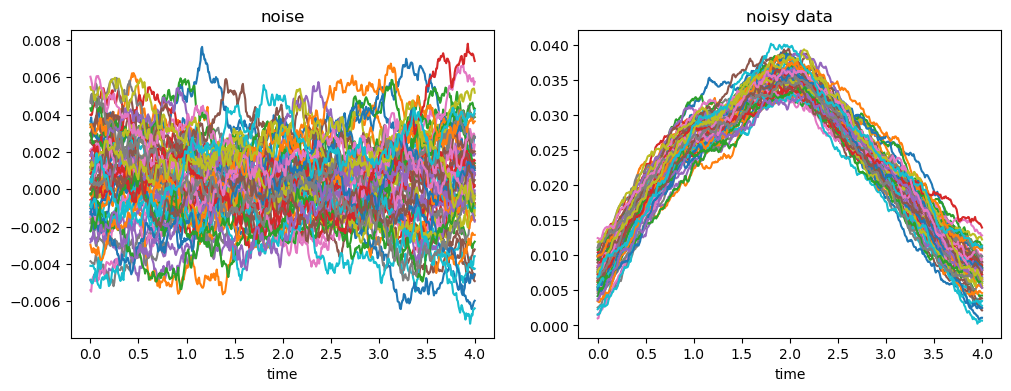

In [11]:
tStart = time.time()

samples = inversionBayes.noise.sample_noise(n_samples = 60)
fig, axs = plt.subplots(1,2, figsize = (12, 4))

for i in range(samples.shape[1]):
    axs[0].plot(grid_t, samples[:, i])
    axs[1].plot(grid_t, data + samples[:, i])
    
axs[0].set_xlabel("time")
axs[0].set_title("noise")

axs[1].set_xlabel("time")
axs[1].set_title("noisy data")
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.")
snr_dB = 10*np.log10(data**2 / np.mean(samples**2, axis = 1))
print("Min / mean / max signal-to-noise ratio (dB): ", np.min(snr_dB), np.mean(snr_dB), np.max(snr_dB)) 

## Convergence

The main trouble we needed to go through for defining the noise models for the Bayesian setting was to make sure they remain consistent in the time-continuous limit, i.e. for `dt` towards zero. In the code below, we test this out.

In [12]:
def noisenorm2(n_steps, NoiseClass, params):
    
    # NavigationCircle was imported as Navigation
    navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

    # point-wise measurements
    detector = DetectorPointwise(fom)

    # initialize drone
    drone = Drone(detector=detector, navigation=navigation, fom=fom)

    # fly in a circle
    alpha = np.array([0.25, 0.2])
    flight = drone.plan_flight(alpha=alpha)

    # measure data
    data = drone.measure(flight=flight, state=state)
    #data = 0.01 * np.sin(flight.grid_t)

    noise = NoiseClass(grid_t=drone.grid_t)
    noise.parameterize_noise_model(c_scaling = params[0], c_diffusion = params[1], c_boundary = params[2])
    inversion = InverseProblem(fom, drone, noise=noise)

    return inversion.compute_noisenorm2(data)

The code below computes the "noise-norm" of the noise-free data measured along the flight path for different `dt`. depending on how many test steps are chosen, this computation takes some time.

In [13]:
tStart = time.time()

steps_test = 2**np.arange(2, 15)+1
vals_test = np.zeros((2, steps_test.shape[0]))

for i in range(steps_test.shape[0]):
    print("Iteration {} / {}".format(i+1, steps_test.shape[0]))
    
    # Deterministic
    vals_test[0, i] = noisenorm2(n_steps = steps_test[i], 
                                 NoiseClass=Noise, 
                                 params=[1e+6, 0, 0])
    
    # Bayes
    vals_test[1, i] = noisenorm2(n_steps = steps_test[i], 
                                 NoiseClass=NoiseBayes, 
                                 params=[1e+3, 1, 0])
    
my_labels = ["deterministic", "Bayes"]

print("Runtime of this block: ", (time.time()-tStart)/60, "min.")

Iteration 1 / 13
Iteration 2 / 13
Iteration 3 / 13
Iteration 4 / 13
Iteration 5 / 13
Iteration 6 / 13
Iteration 7 / 13
Iteration 8 / 13
Iteration 9 / 13
Iteration 10 / 13
Iteration 11 / 13
Iteration 12 / 13
Iteration 13 / 13
Runtime of this block:  0.016554649670918783 min.


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/var/folders/_k/q9sdsmfx2j35cmp3z9tn84km0000gp/T/ipykernel_26172/283602108.py:10: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel("time discretization $\Delta t$")


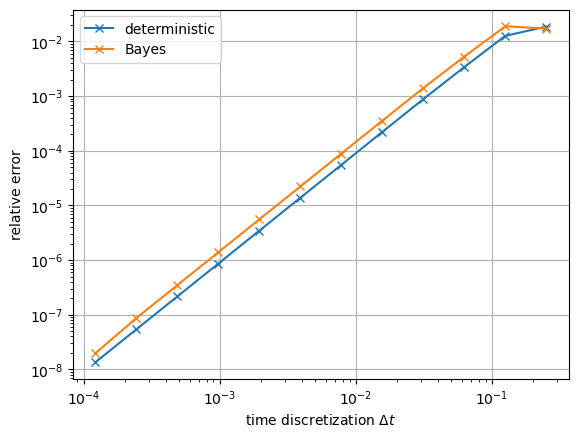

In [14]:
fig, ax = plt.subplots(1,1)

for i in range(2):
    ax.loglog(1/(steps_test[:-1]-1), 
                  np.abs(vals_test[i, 1:]-vals_test[i, :-1]) / vals_test[i, -1], 
                  label=my_labels[i], 
                  marker = "x")

ax.legend()
ax.set_xlabel("time discretization $\Delta t$")
ax.set_ylabel("relative error")
ax.grid(True)


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/var/folders/_k/q9sdsmfx2j35cmp3z9tn84km0000gp/T/ipykernel_26172/1419255232.py:10: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel("time discretization $\Delta t$")


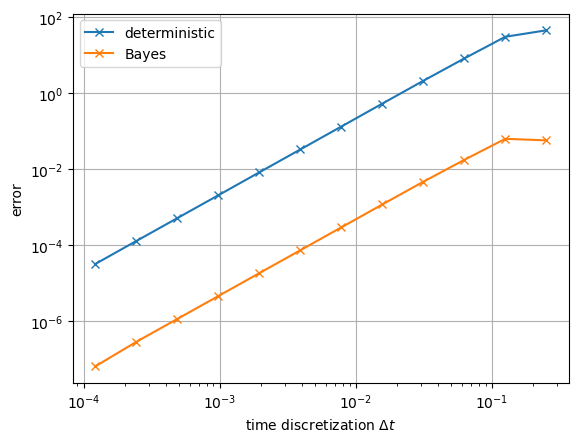

In [15]:
fig, ax = plt.subplots(1,1)

for i in range(2):
    ax.loglog(1/(steps_test[:-1]-1), 
                  np.abs(vals_test[i, 1:]-vals_test[i, :-1]), 
                  label=my_labels[i], 
                  marker = "x")

ax.legend()
ax.set_xlabel("time discretization $\Delta t$")
ax.set_ylabel("error")
ax.grid(True)

## The End.

In [16]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 5.24372949997584 min
